In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import graphviz
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz

In [2]:
# To use 한글 font in graphs
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus']=False

In [3]:
ds_hmeq = pd.read_csv("./csvfiles/HMEQ.csv")

In [4]:
ds_hmeq.isnull().sum()

BAD          0
LOAN         0
MORTDUE      0
VALUE       14
REASON       0
JOB         81
YOJ        205
DEROG        0
DELINQ      30
CLAGE       37
NINQ        56
CLNO         0
DEBTINC      0
dtype: int64

In [5]:
ds_hmeq["JOB"].fillna("Other", inplace = True)
ds_hmeq.fillna(ds_hmeq.mean(), inplace = True)

In [6]:
ds_hmeq_dummy = pd.get_dummies(ds_hmeq)
ds_hmeq_dummy.head()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,REASON_DebtCon,REASON_HomeImp,JOB_Mgr,JOB_Office,JOB_Other,JOB_ProfExe,JOB_Sales,JOB_Self
0,1,1700,30548,40320.0,9.0,0,0.0,101.466002,1.0,8,37.113614,0,1,0,0,1,0,0,0
1,1,1800,28502,43034.0,11.0,0,0.0,88.766030,0.0,8,36.884894,0,1,0,0,1,0,0,0
2,0,2300,102370,120953.0,2.0,0,0.0,90.992533,0.0,13,31.588503,0,1,0,1,0,0,0,0
3,1,2400,34863,47471.0,12.0,0,0.0,70.491080,1.0,21,38.263601,0,1,1,0,0,0,0,0
4,0,2400,98449,117195.0,4.0,0,0.0,93.811775,0.0,13,29.681827,0,1,0,1,0,0,0,0


In [7]:
np.random.seed(seed = 1234)
msk = np.random.rand(ds_hmeq_dummy.shape[0]) < 0.7
ds_hmeq_train = ds_hmeq_dummy[msk]
ds_hmeq_test = ds_hmeq_dummy[~msk]

ds_hmeq_train_y = ds_hmeq_train["BAD"]
ds_hmeq_train_x = ds_hmeq_train.drop("BAD", axis = 1)
ds_hmeq_test_y = ds_hmeq_test["BAD"]
ds_hmeq_test_x = ds_hmeq_test.drop("BAD", axis = 1)

print("train data X size:", ds_hmeq_train_x.shape)
print("train data y size:", ds_hmeq_train_y.shape)
print("test data X size:", ds_hmeq_test_x.shape)
print("test data y size:", ds_hmeq_test_y.shape)



train data X size: (2604, 18)
train data y size: (2604,)
test data X size: (1144, 18)
test data y size: (1144,)


In [8]:
from sklearn.model_selection import train_test_split

ds_hmeq_y = ds_hmeq_dummy["BAD"]
ds_hmeq_x = ds_hmeq_dummy.drop("BAD", axis = 1)
train_x2, test_x2, train_y2, test_y2 = train_test_split(ds_hmeq_x, ds_hmeq_y, test_size=0.30, random_state=1234)
print("train data X size:", train_x2.shape)
print("train data y size:", train_y2.shape)
print("test data X size:", test_x2.shape)
print("test data y size:", test_y2.shape)


train data X size: (2623, 18)
train data y size: (2623,)
test data X size: (1125, 18)
test data y size: (1125,)


In [9]:
tree_uncustom = DecisionTreeClassifier(random_state=1234, )
tree_uncustom.fit(ds_hmeq_train_x, ds_hmeq_train_y)
# 훈련 데이터 정확도
print("Accuray on training set:{:.3f}".format(tree_uncustom.score(ds_hmeq_train_x, ds_hmeq_train_y)))

# test 데이터 정확도
print("Accuray on test set:{:.3f}".format(tree_uncustom.score(ds_hmeq_test_x, ds_hmeq_test_y)))

Accuray on training set:1.000
Accuray on test set:0.927


In [10]:
tree_uncustom.get_params

<bound method BaseEstimator.get_params of DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1234,
            splitter='best')>

In [11]:
#train 및 test정확도 결과 저장용
train_accuracy = []
test_accuracy = []

# 적용가능한 criterion : gini, entropy
para_criterion = ['gini', 'entropy']

# para_criterion 별로 트리 모델 생성 및 정확도 값 저장
for criterion in para_criterion:
    tree1 = DecisionTreeClassifier(criterion = criterion, random_state=1234)
    tree1.fit(ds_hmeq_train_x, ds_hmeq_train_y)
    train_accuracy.append(tree1.score(ds_hmeq_train_x, ds_hmeq_train_y))
    test_accuracy.append(tree1.score(ds_hmeq_test_x, ds_hmeq_test_y))
    
#저장된 모델의 criterion 및 train/test 데이터 분류 정확도 테이블 생성

ds_accuracy1 = pd.DataFrame()
ds_accuracy1["Criterion"] = para_criterion
ds_accuracy1["TrainAccuracy"] = train_accuracy
ds_accuracy1["TestAccuracy"] = test_accuracy
ds_accuracy1.round(3)


,Criterion,TrainAccuracy,TestAccuracy
0,gini,1.0,0.927
1,entropy,1.0,0.921


### 의사결정 나무 모델 Parameter 조정
- max_depth : 최대 깊이 변경

In [12]:
#train 및 test 정확도 결과 저장용
train_accuracy =[]
test_accuracy = []

#parameter 결과 테이블을 위해
para_criterion = []
para_max_depth = []

#최대 깊이 1~10까지 순차 실행
n_iter_depth = 10

#적용가능한 criterion: gini, entrophy
list_criterion = ["gini", 'entropy']

#criterion:gini, entropy & max_depth : 1~10까지 반복 실행

for criterion in list_criterion:
    for depth in range(1, n_iter_depth+1):
        tree2 = DecisionTreeClassifier(criterion=criterion, max_depth=depth, random_state=1234)
        tree2.fit(ds_hmeq_train_x, ds_hmeq_train_y)
        
        train_accuracy.append(tree2.score(ds_hmeq_train_x, ds_hmeq_train_y))
        test_accuracy.append(tree2.score(ds_hmeq_test_x, ds_hmeq_test_y))
        para_criterion.append(criterion)
        para_max_depth.append(depth)
        


In [13]:
ds_accuracy2 = pd.DataFrame()
ds_accuracy2["Criterion"] = para_criterion
ds_accuracy2["Depth"] = para_max_depth
ds_accuracy2["TestAccuracy"] = test_accuracy
ds_accuracy2["TrainAccuracy"] = train_accuracy
ds_accuracy2.round(3)

,Criterion,Depth,TestAccuracy,TrainAccuracy
0,gini,1,0.927,0.924
1,gini,2,0.932,0.930
2,gini,3,0.932,0.931
3,gini,4,0.934,0.934
4,gini,5,0.934,0.937
5,gini,6,0.937,0.938
6,gini,7,0.934,0.944
7,gini,8,0.935,0.952
8,gini,9,0.936,0.959
9,gini,10,0.943,0.965


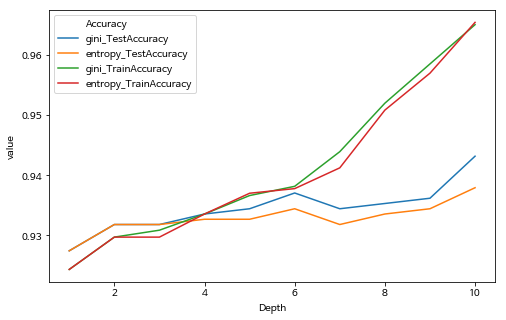

In [14]:
plt.figure(figsize=(8,5))
ds_accuracy2_melt = pd.melt(ds_accuracy2, id_vars=["Criterion", 'Depth'])
ds_accuracy2_melt["Accuracy"] = ds_accuracy2_melt["Criterion"] + "_" + ds_accuracy2_melt["variable"]
sns.lineplot(x="Depth", y="value", hue="Accuracy", data=ds_accuracy2_melt)

 -> 깊이가 깊어질수록 트리가 세분화 되므로 정확도는 높아짐. 단, 과적합 주의

#### - min_sample_size : 잎사귀 수 제한

In [16]:
#train 및 test 정확도 결과 저장용
train_accuracy =[]
test_accuracy = []

#parameter 결과 테이블을 위해
para_criterion = []
para_max_depth = []
para_min_leaf_size = []

# 최대 깊이 1~10까지 순차 실행
max_dapth = 10

# 잎사귀 수 10~50까지 10단위로 순차 실행
list_min_leaf_size = [i * 10 for i in range (1,6)]

# criterion: gini, entropy & min_sample_size : 10~50까지 반복 실행

#적용가능한 criterion: gini, entrophy
list_criterion = ["gini", 'entropy']

#criterion:gini, entropy & min_sample_size : 10~50까지 반복 실행

for criterion in list_criterion:
    for leafsize in list_min_leaf_size:
        tree3 = DecisionTreeClassifier(criterion=criterion, max_depth=max_dapth,
                                       min_samples_leaf=leafsize, random_state=1234)
        tree3.fit(ds_hmeq_train_x, ds_hmeq_train_y)
        train_accuracy.append(tree3.score(ds_hmeq_train_x, ds_hmeq_train_y))
        test_accuracy.append(tree3.score(ds_hmeq_test_x, ds_hmeq_test_y))
        para_criterion.append(criterion)
        para_max_depth.append(depth)
        para_min_leaf_size.append(leafsize)

In [17]:
ds_accuracy3 = pd.DataFrame()
ds_accuracy3["Criterion"] = para_criterion
ds_accuracy3["Depth"] = para_max_depth
ds_accuracy3["MinLeafSize"] = para_min_leaf_size
ds_accuracy3["TestAccuracy"] = test_accuracy
ds_accuracy3["TrainAccuracy"] = train_accuracy
ds_accuracy3.round(3)

,Criterion,Depth,MinLeafSize,TestAccuracy,TrainAccuracy
0,gini,10,10,0.935,0.945
1,gini,10,20,0.924,0.931
2,gini,10,30,0.929,0.929
3,gini,10,40,0.924,0.926
4,gini,10,50,0.930,0.924
5,entropy,10,10,0.930,0.944
6,entropy,10,20,0.925,0.930
7,entropy,10,30,0.933,0.927
8,entropy,10,40,0.927,0.924
9,entropy,10,50,0.930,0.924


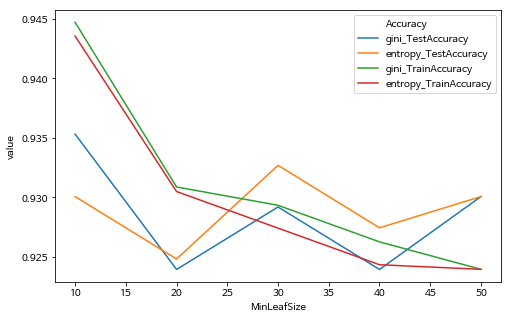

In [18]:
# 정확도를 그래프로 표현
plt.figure(figsize=(8,5))
ds_accuracy3_melt = pd.melt(ds_accuracy3, id_vars=["Criterion", 'Depth', 'MinLeafSize'])
ds_accuracy3_melt["Accuracy"] = ds_accuracy3_melt["Criterion"] + "_" + ds_accuracy3_melt["variable"]

sns.lineplot(x="MinLeafSize", y="value", hue="Accuracy", data=ds_accuracy3_melt)

* train 데이터(파랑,노랑)는 gini/entropy 둘 다 잎사귀 수를 낮출수록 정확도가 높아짐. 
* 잎사귀 수가 낮을수록 모델을 복잡하게 분리
* test 데이터(빨강, 초록)는 정확도가 자아지고 높아지기를 반복
* 잎사귀 수가 20또는 40인 모델보다 30인 모델이 더 나아 보임

In [22]:
tree = DecisionTreeClassifier(criterion='gini',max_depth=4, random_state=1234)
tree.fit(ds_hmeq_train_x, ds_hmeq_train_y)
# 트리 모델을 tree.dot 파일로 저장
export_graphviz(tree, out_file="tree.dot", class_names = ['0', '1'],
               feature_names = ds_hmeq_train_x.columns, impurity = False, filled=True)

In [23]:
#PATH 설정 : graphviz를 설치 했다면, 설치 된 경로를 설정
os.environ["PATH"] += os.pathsep + "./"


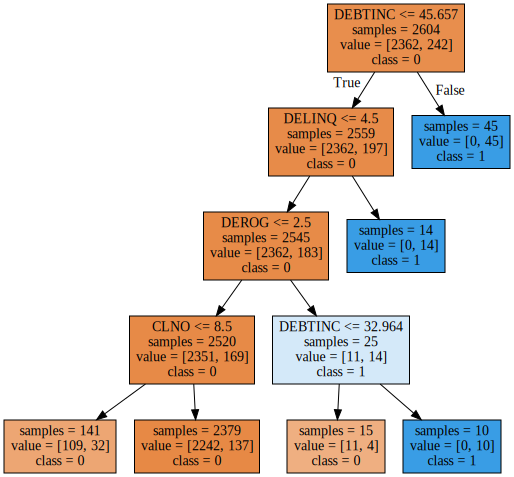

In [24]:
# graphviz를 이용해 트리 모델 시각화
with open("tree.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

1. 부모 노드(해석방법 예) : 부모 노드에서 부채비율(DEBTINC)이 45.101보다 작거나 같으면 True, 크면 False로 분류. 이때 모든 노드에 대해서 True / False의 방향이 동일하게 적용
2. Leaf 또는 끝 노드 : 44개의 자료를 대출 채무 불이행(target, BAD=1)으로 분류했고, 부모 노드의 조건을 역순으로 조합해서 해석햄 -> 가장 오래된 계좌의 달의 수 (CLAGE)가 234.724보다 작거나 같고, 부채비율 (DEBTINC)이 45.101보다 큰 경우에 대출 채무 불이행으로 분류

* 노드에서 samples는 해당 노드의 전체 자료 수이고 value는 0과 1의 각각의 자료 수. 순수 노드가 아닐 경우에는 자료수가 많은 쪽으로 class를 분류

## 잎사귀 수(leaf size)를 변경하면서 모델의 시각화 결과를 확인

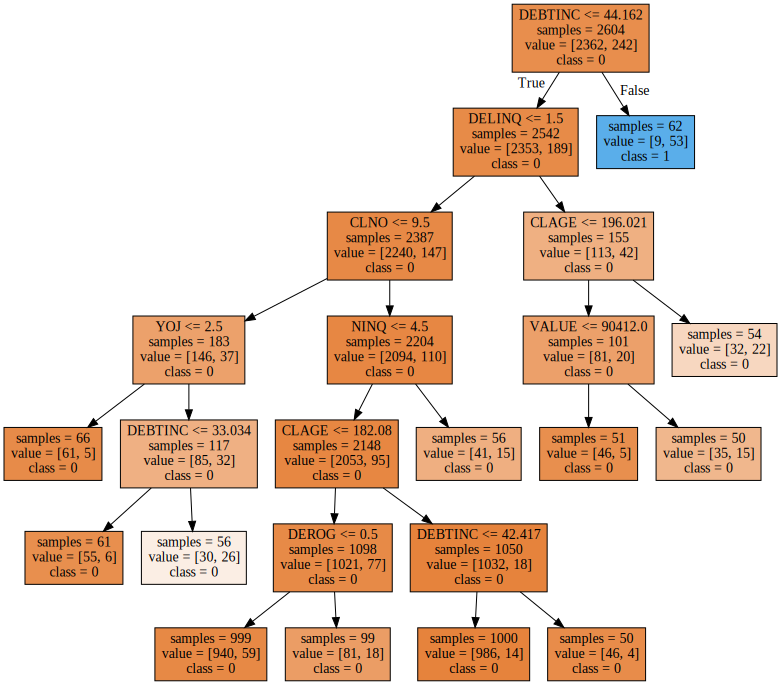

In [25]:
# 새로운 트리 모델 생성(min_samples_leaf = 50인 트리모델)
tree4 = DecisionTreeClassifier(criterion = "gini", max_depth=6, min_samples_leaf=50, random_state=1234)
tree5 = tree4.fit(ds_hmeq_train_x, ds_hmeq_train_y)
# tree2.dot으로 결과 저장
export_graphviz(tree5, out_file='tree2.dot', class_names = ['0', '1'],
               feature_names=ds_hmeq_train_x.columns, impurity=False, filled=True)
# tree2. dot 그리기
with open("tree2.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))


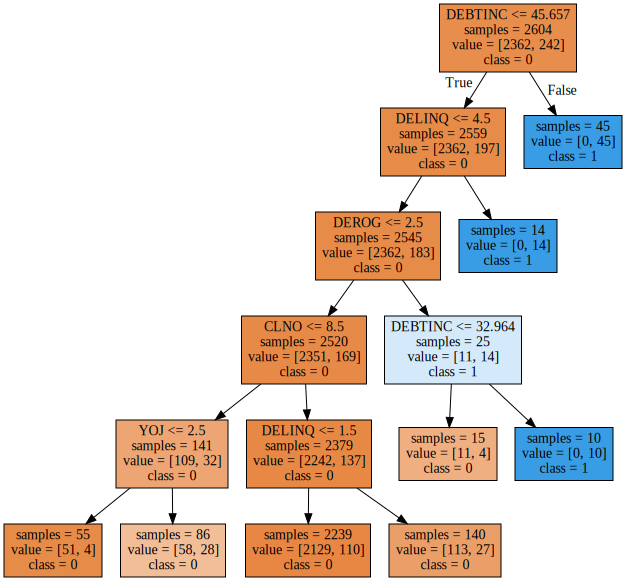

In [32]:
# 새로운 트리 모델 생성 (min_sample_leaf = 200인 트리모델)

tree4 = DecisionTreeClassifier(criterion = 'gini', max_depth=5, min_samples_leaf=10, random_state=1234)
tree5 = tree4.fit(ds_hmeq_train_x, ds_hmeq_train_y)

#tree3.dot으로 결과 저장
export_graphviz(tree5, out_file="tree3.dot", class_names = ['0', '1'],
               feature_names = ds_hmeq_train_x.columns, impurity=False, filled=True)

#tree3.dot 그리기
with open('tree3.dot') as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

## 결론 도출
- feature_importances_ : 설명변수의 중요도

In [33]:
# tree.feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
ds_feature_importance = pd.DataFrame()
ds_feature_importance["Feature"] = ds_hmeq_train_x.columns
ds_feature_importance["Importance"] = tree.feature_importances_
#ds_feature_importance의 테이블을 중요도별로 정렬
ds_feature_importance=ds_feature_importance.sort_values("Importance", ascending=False)
ds_feature_importance.round(3)

,Feature,Importance
9,DEBTINC,0.652
5,DELINQ,0.191
4,DEROG,0.096
8,CLNO,0.061
11,REASON_HomeImp,0.000
16,JOB_Sales,0.000
15,JOB_ProfExe,0.000
14,JOB_Other,0.000
13,JOB_Office,0.000
12,JOB_Mgr,0.000


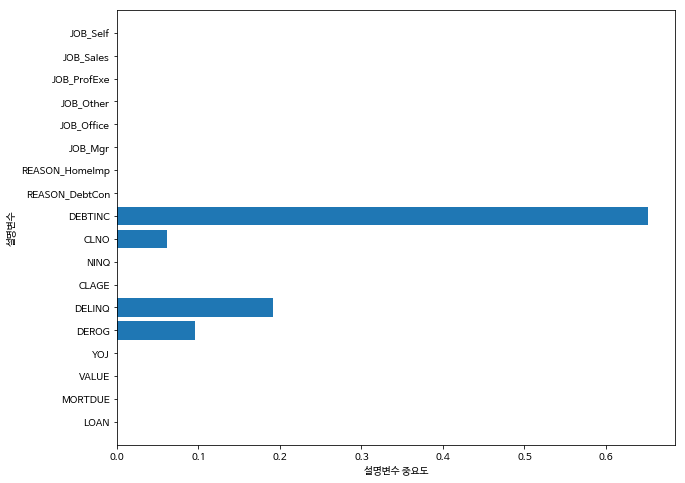

In [28]:
def plot_feature_importances(model):
    n_features = ds_hmeq_train_x.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align="center")
    plt.yticks(range(n_features), ds_hmeq_train_x.columns)
    plt.xlabel("설명변수 중요도")
    plt.ylabel('설명변수')
    plt.ylim(-1, n_features)

# 설명 변수 중요도 그래프 함수 실행
plt.figure(figsize=(10,8))
plot_feature_importances(tree)

* 부채비율(DEBTINC)이 가장 유의한 변수로보임
* 연체된 신용 한도의 수(DELINQ)가 2번째로 유의한 변수